# Tipo fijo

Vamos a calcular las hipotecas que tienen un plazo fijo.

La fórmula es de la cuota es $cuota = \frac{capital\cdot interes}{100(1-(1+\frac{interes}{100})^{-1})}$

In [1]:
from __future__ import division
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def calcula_cuota(capital, interes_anual, meses):
    interes = pow(1+interes_anual/100, 1/12.0) - 1   
    num = capital*interes
    denom = (1-(1+interes)**(-meses))
    return num/denom

def calcula_hipoteca_tipo_fijo(capital, interes_anual, anyos):
    cuota = calcula_cuota(capital ,interes_anual, 12*anyos)
    return cuota * anyos * 12

calcula_cuota(183000, 2.7, 30*12)

739.0752242459761

## Estudio de las ofertas a tipo fijo

### 20 años al 2.30%

In [3]:
print calcula_hipoteca_tipo_fijo(1, 2.3, 20)

1.24575183659


### 30 años al 2.70%

In [4]:
print calcula_hipoteca_tipo_fijo(1, 2.7, 30)


1.45391847393


# Hipoteca Tipo Variable

Hacer un estudio de una hipoteca a tipo variable con los valores actuales es engañoso porque ahora están anómalamente bajos (valores negativos). En la vida de la hipoteca es esperable que el Euribor experimente variaciones tal y como lo ha hecho en el pasado por tanto lo primero sería tratar de caracterizar al Euribor de alguna manera y ver cuál es la horquilla esperada de variación de la cuota de la hipoteca durante la vida de la misma.

## Distribución de los saltos del Euribor

Cogeremos las datos actualizados de [mi repositorio](https://github.com/tonicebrian/euribor/). Es la serie mensual del euribor desde 1999. 

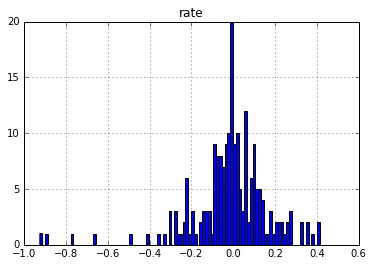

In [5]:
euribor = pd.read_csv('data/euribor-12m-monthly.csv', index_col=0, usecols=[0,1])
deltas = euribor.diff().dropna()
deltas.hist(bins=100);

Veamos si los deltas siguen una distrbución gaussiana

In [6]:
import scipy.stats as stats
stats.normaltest(deltas)

NormaltestResult(statistic=array([ 79.52586207]), pvalue=array([  5.38491021e-18]))

El *p-valor* cercano a cero nos está diciendo que no podemos asumir una distribución gaussiana de los deltas. Podríamos tratar de modelizar el Euribor utilizando modelos complejos como el GARCH pero lo que vamos a hacer es asumir un *random walk* con la función de distribución del histograma de los valores históricos.


In [7]:
N = len(deltas)
F = np.array(range(N))/float(N)
x = np.sort(deltas['rate'])
def genera_valor():
    rnd = np.random.uniform()
    i = int(N*rnd)
    return x[i]


Ahora que somos capaces de generar una distribución con una forma similar a los incrementos históricos del Euribor, podemos también generar las series temporales del euribor en el periodo especificado. Debido a que partimos de un Euribor negativo a 8 de Mayo de 2016, un paseo aleatorio libre daría lugar a situaciones que son bastante improbables que se produzcan. Por ejemplo, con diferenciales típicos en torno al 1% si el Euribor bajase del -1% implicaría que los bancos me pagarían por tener una hipoteca. No se vosotros pero me cuesta verlo. Le añaderé una corrección a la simulación para que alcanzar ese -1% sea prácticamente imposible, dejándole fluctuar libremente cuando esté por encima del 0%.

In [8]:
euribor_actual = -0.013
def genera_euribor(anyos):
    meses = 12*anyos
    ultimo = euribor_actual
    valores = [euribor_actual]
    for i in xrange(meses):
        delta = genera_valor()
        if (ultimo < 0) & (delta < 0):
            ponderacion = 1/(1+ultimo)
            ultimo = ultimo + delta/ponderacion
        else:
            if ultimo+delta < 0:
                ultimo = 0
            else:
                ultimo = ultimo+delta

        valores.append(ultimo)
    return valores



Vamos a plotear una serie temporal a 30 años generado por este método. 

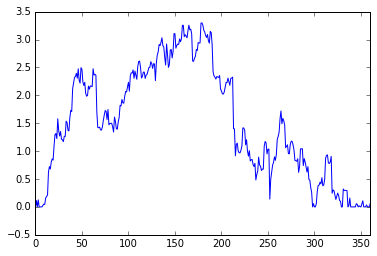

In [9]:
pd.Series(genera_euribor(30)).plot();

Generamos ahora unas 100 series sobre las que haremos las simulaciones

In [10]:
NUM_SIMULACIONES=100
def simula_euribor(anyos):
    return [genera_euribor(anyos) for i in xrange(NUM_SIMULACIONES)]


In [11]:
NUM_SIMULACIONES=1
def capital_pendiente(cuota, meses_amortizados, anyos_hipoteca, interes_mensual):
    meses_totales = 12*anyos_hipoteca
    num = 1 - (1+interes_mensual)**(meses_amortizados-meses_totales)
    denom = interes_mensual
    return cuota*num/denom
    
def calcula_hipoteca_variable(capital, diferencial, revision, anyos):
    """anyos de la hipoteca.
    revision cada cuantos meses se actualiza el interés"""
    num_revisiones = int(12*anyos/revision)
    euribors = simula_euribor(anyos)

    total_pagado = 0

    for euribor in euribors:
        cuota = calcula_cuota(capital, euribor[0]+diferencial, 12*anyos)
        for i in xrange(1, num_revisiones):
            mes_en_curso = i*revision
            interes_anual = euribor[mes_en_curso] + diferencial
            interes_mensual = pow(1+interes_anual/100, 1/12) - 1   
            total_pagado += cuota*revision
            cap_pendiente = capital_pendiente(cuota, mes_en_curso, anyos, interes_mensual)
            cuota = calcula_cuota(cap_pendiente, interes_anual, 12*anyos - mes_en_curso)
            #print "tenemos una cuota %f con un interes anual %f y nos queda un capital pendiente %d y meses restantes %d" % (cuota, interes_anual, cap_pendiente,  12*anyos - mes_en_curso)
            

    return total_pagado/NUM_SIMULACIONES


Vamos a calcular varios escenarios

In [22]:
ofertas = pd.DataFrame({'nombre': ['bankinter_20', 'triodos_20', 'bankinter_30', 'triodos_30'],
                           'diferencial': [0.95, 1.18]*2,
                           'revision':[6, 12]*2,
                           'anyos': [20, 20, 30, 30]
})
capital_prestamo = 180000
escenarios['total'] = ofertas.apply(lambda row:calcula_hipoteca_variable(
                                                      capital_prestamo,
                                                      row['diferencial'],
                                                      row['revision'],
                                                      row['anyos']), axis=1).apply(np.int)
escenarios['interes_total'] = (escenarios['total'] - capital_prestamo).apply(np.int)



Comparativa

In [32]:
comparativa = ofertas.copy()
media_euribor = 1
comparativa['total'] = comparativa.apply(lambda row:calcula_hipoteca_tipo_fijo(
                                                      capital_prestamo,
                                                      row['diferencial']+media_euribor,
                                                      row['anyos']), axis=1).apply(np.int)
comparativa['cuota'] = comparativa.apply(lambda row:calcula_cuota(
                                                      capital_prestamo,
                                                      row['diferencial']+media_euribor,
                                                      12*row['anyos']), axis=1).apply(np.int)

comparativa['premium'] = comparativa['total'] - capital_prestamo
comparativa

   anyos  diferencial        nombre  revision   total  cuota  premium
0     20         0.95  bankinter_20         6  217169    904    37169
1     20         1.18    triodos_20        12  221799    924    41799
2     30         0.95  bankinter_30         6  237341    659    57341
3     30         1.18    triodos_30        12  244682    679    64682